In [37]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import sigpy as sp
import cupy as cp
import numpy as np
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from admm.utils_moco import stacked_nufft_operator,golden_angle_2d_readout, golden_angle_coords_3d, pocs, phase_based_gating_peak_to_peak, phase_based_gating, create_gates

### Load Data and Reshape

In [5]:
data_path = Path('/home/lilianae/data/NaF_MtSinai/')
output_path = parent_folder/Path('data/processed/')
print(f'output path = {output_path}')

if not os.path.exists(output_path):
    os.makedirs(output_path)

data_file = data_path /'anon_meas_MID00118_FID60738_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS.dat'

multi_twix = twixtools.read_twix(str(data_file))
mapped = twixtools.map_twix(multi_twix)

output path = /home/lilianae/projects/data/processed
Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:12<00:00, 1.34GB/s]


In [ ]:
## mapped[0] is sens data

print(mapped[0])
data_0 = mapped[0]['image']
print(data_0.non_singleton_dims)
data_0.flags['remove_os']=True
print(data_0.non_singleton_dims)
print(data_0.shape)
# won't work:
#data_0 = data_0[:].squeeze()
echo_num=0                                                  # first echo is spoke data
num_points = int(mapped[0]['hdr']['Config']['NImageLins'])  # number of points on one spoke
kspace_0 = data_0[...,echo_num,0,0,0,:,0,0,:,:,:num_points]
kspace_0 = kspace_0.squeeze()
print(kspace_0.shape)
kspace_0 = np.transpose(kspace_0,(2,0,1,3))
print(kspace_0.shape)  ## Shape = (15, 58, 2002, 256) -> (channels, partitions, lines, columns)


In [70]:
# hdr = mapped[0]['hdr']
# print(hdr)

### Determine Center of K-space

Text(0, 0.5, 'slices')

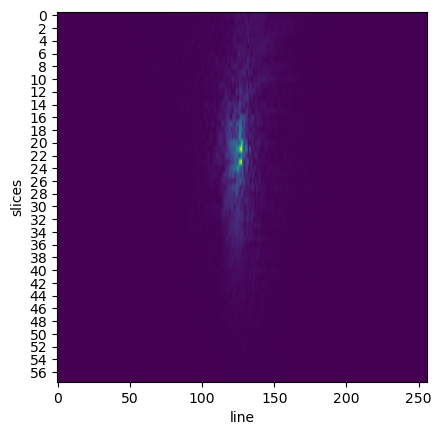

In [14]:
# show slice x line; check, where the kspace center in the through-slice 
# direction is (may not be in the exact middle due to partial Fourier etc.)
plt.imshow(np.abs(kspace_0[0,:,0,...]), aspect=kspace_0.shape[3]/kspace_0.shape[1])
gca = plt.gca()
gca.set_yticks(np.arange(0,kspace_0.shape[1],2))
gca.set_xlabel("line")
gca.set_ylabel("slices")

Text(0, 0.5, 'spokes (first 100)')

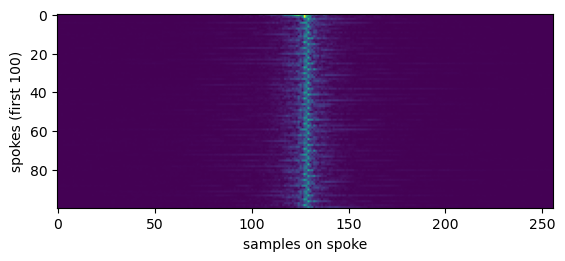

In [ ]:
# quick check: show data for a couple of spokes, kspace center should be in the middle:
center_slice_index = 22 # from plot above

plt.imshow(np.abs(kspace_0[0,center_slice_index,0:100,...]))
plt.xlabel('samples on spoke')
plt.ylabel('spokes (first 100)')

### Determine coil to use for respiratory signal

Show signal for a number of coils, check visually which coil shows a good resp. signal (roughly 10-14 peaks per minute)

In [30]:
# # get raw signal from k-space center:


# num_slices = kspace_0.shape[1] # in EMOCO example
# TR = float(mapped[0]['hdr']['Config']['TR'])/1000 # in msecs
# TR_per_volume = num_slices*TR # interval between acqs of central spoke in msecs

# one_minute_timescale = np.arange(0,60., TR_per_volume/1000.)

# fs=1000./TR_per_volume  # sample rate
# cutoff = 0.25           # in Hz -> roughly 15 resp/minute
# nyq = 0.5*fs
# n = len(one_minute_timescale)

# # lowpass filter:
# def butter_lowpass_filter(data, cutoff, fs, order):
#     normal_cutoff = cutoff / nyq
#     # Get the filter coefficients 
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = filtfilt(b, a, data)
#     return y

# coil=0 
# fig, axs = plt.subplots(4,4,figsize=(20,20))
# for r in range(4):
#     for c in range(4):
#         if coil==15:
#             break
#         # take average of two values around the center:
#         signal = np.mean(np.abs(kspace_0[coil,center_slice_index,:len(one_minute_timescale),127:129]), axis=-1)
        
#         signal_lp_flt = butter_lowpass_filter(signal, cutoff, fs, order=2)

#         axs[r,c].plot(one_minute_timescale, signal, label='raw sig.')
#         axs[r,c].plot(one_minute_timescale, signal_lp_flt, label='filtered sig.')
#         axs[r,c].set_xlabel('seconds')
#         axs[r,c].set_title('coil ' + str(coil))
#         axs[r,c].legend()
#         coil+=1

173
(15, 58, 2002, 256)


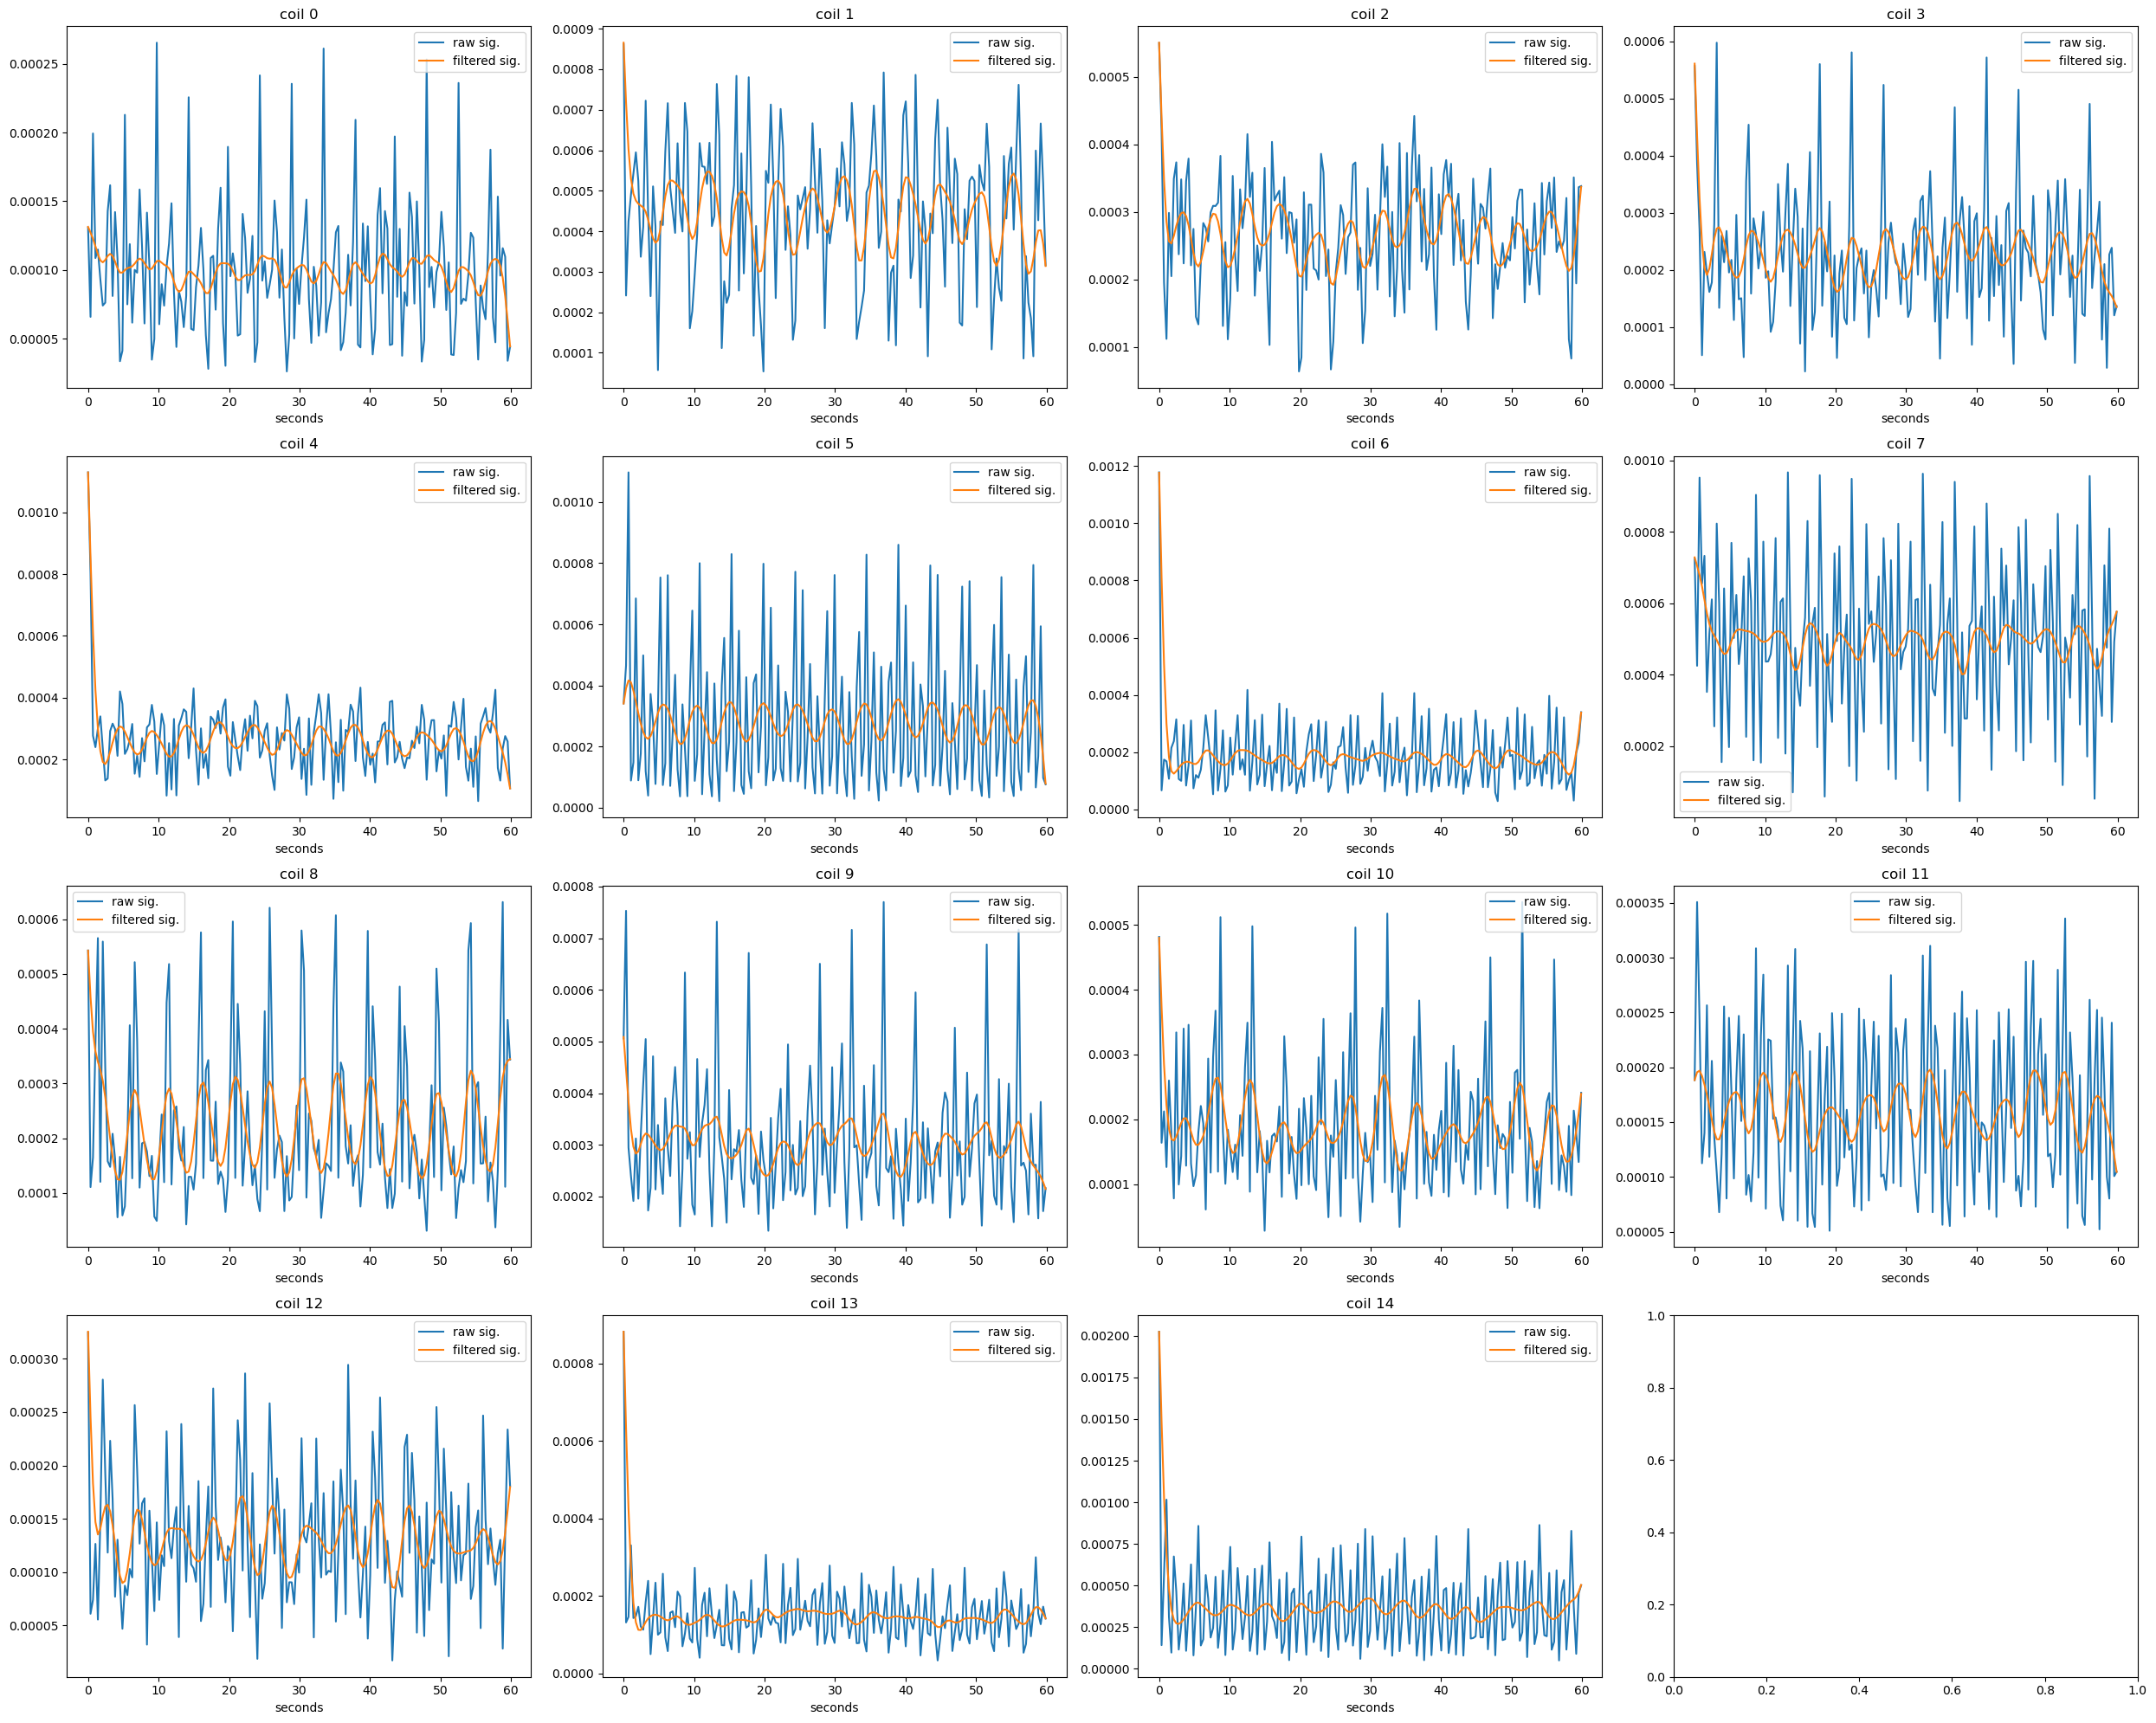

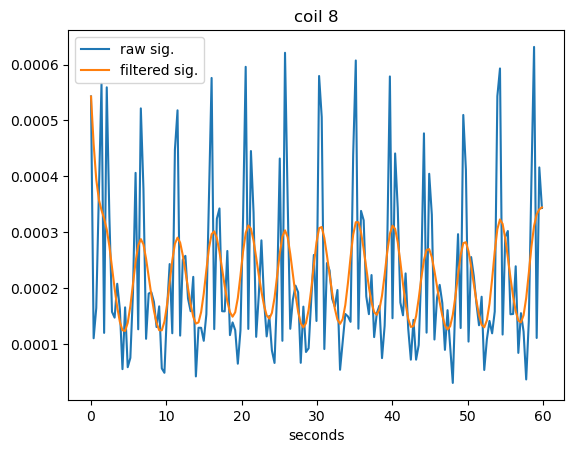

In [31]:

num_slices = kspace_0.shape[1] 
TR = float(mapped[0]['hdr']['Config']['TR'])/1000 # in msecs
TR_per_volume = num_slices*TR # interval between acqs of central spoke in msecs

one_minute_timescale = np.arange(0,60., TR_per_volume/1000.)

fs=1000./TR_per_volume  # sample rate
cutoff = 0.25          # in Hz -> roughly 15 resp/minute
nyq = 0.5*fs
n = len(one_minute_timescale)
print(n)

# lowpass filter:
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

coil=0 
fig, axs = plt.subplots(4,4,figsize=(25,20))

print(kspace_0.shape)
for r in range(4):
    for c in range(4):
        # take average of two values around the center:
        if coil==15:
            break
        signal = np.mean(np.abs(kspace_0[coil,center_slice_index,:len(one_minute_timescale),132:134]), axis=-1)
        
        signal_lp_flt = butter_lowpass_filter(signal, cutoff, fs, order=2)

        axs[r,c].plot(one_minute_timescale, signal, label='raw sig.')
        axs[r,c].plot(one_minute_timescale, signal_lp_flt, label='filtered sig.')
        axs[r,c].set_xlabel('seconds')
        axs[r,c].set_title('coil ' + str(coil))
        axs[r,c].legend()
        coil+=1
plt.tight_layout()


plt.figure(2)
coil_idx = 8
signal = np.mean(np.abs(kspace_0[coil_idx,center_slice_index,:len(one_minute_timescale),132:134]), axis=-1)
signal_lp_flt = butter_lowpass_filter(signal, cutoff, fs, order=2)
plt.plot(one_minute_timescale, signal, label='raw sig.')
plt.plot(one_minute_timescale, signal_lp_flt, label='filtered sig.')
plt.xlabel('seconds')
plt.title('coil ' + str(coil_idx))
plt.legend()


TR:  6.0
TR per vol:  348.0
T:  696.6959999999999


Text(0.5, 1.0, 'Full filtered signal from coil 8')

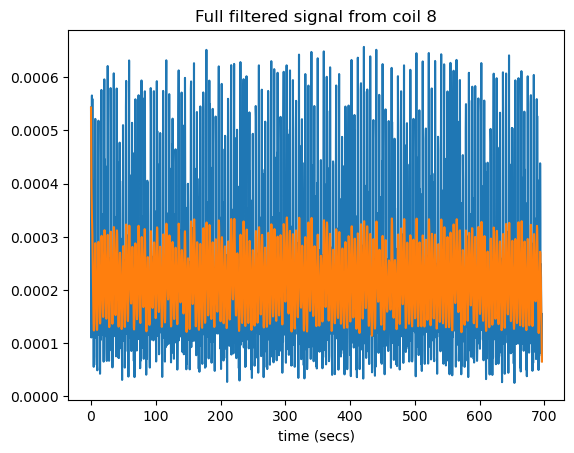

In [34]:
# choose coil, then show full, filtered signal

coil_index = 8
num_spokes = kspace_0.shape[2]
num_slices = kspace_0.shape[1] # in EMOCO example
TR = float(mapped[0]['hdr']['Config']['TR'])/1000 # in msecs
TR_per_volume = num_slices*TR # interval between acqs of central spoke in msecs
num_spokes = kspace_0.shape[2]
T = num_spokes*(TR_per_volume/1000.)
full_time_scale = np.arange(0,T, TR_per_volume/1000  )
print("TR: ", TR)
print("TR per vol: ", TR_per_volume)
print("T: ", T)
# print("full time scale: ", full_time_scale)

signal = np.mean(np.abs(kspace_0[coil_index,center_slice_index,:,132:134]), axis=-1)

# cutoff, sample rate, nyquist as above
n = len(signal)

y = butter_lowpass_filter(signal, cutoff, fs, order=2)

plt.plot(full_time_scale, signal)
plt.plot(full_time_scale,y)
plt.xlabel('time (secs)')
plt.title(f'Full filtered signal from coil {coil_index}')

### Perform Gating

In [38]:
# divide phase between two peaks of the signal evenly.
# Thus, in- and expiration go into different gates.
num_gates = 5
idx = phase_based_gating_peak_to_peak(y,num_gates, order=25)

# divide kspace and spoke data:
img_shape = (58,256,256) # for EMOCO data
num_points = kspace_0.shape[3]
coords = golden_angle_coords_3d(img_shape,num_spokes,num_points)
data_bins, spoke_bins = create_gates(kspace_0,coords,idx,num_gates)

In [61]:
print(spoke_bins[4].shape)
print(len(spoke_bins))

(58, 218, 256, 3)
5


### Reconstruction

In [62]:
# Sensitiviy data should come along with the MR data. For testing, a uniform sensitivity map is used:
sens_shape = (kspace_0.shape[0], *img_shape)
sens = np.ones(sens_shape, dtype=np.complex64)

# create Fourier ops:
Fs=[]
for i in range(len(spoke_bins)):
    Fs.append(sp.mri.linop.Sense(sens,coord=spoke_bins[i]))

# normalize Fourier OPs (take all Fourier ops as a single, large op for this):  
device=0
Fs_diag=sp.linop.Diag(Fs,iaxis=2,oaxis=2)   
max_eig_op = sp.app.MaxEig(Fs_diag.H * Fs_diag, dtype=cp.complex64, device=device,max_iter=30).run()  
for i in range(len(spoke_bins)):
    Fs[i]  = (1/np.sqrt(max_eig_op))*Fs[i]

# NOTE:
# After reconstruction, derive a scaling factor for the kspace data such that when reconstructed, image data lies in [0,1]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

In [64]:
print(Fs[0])
print((data_bins[0].shape))

<[15, 58, 259, 256]x[58, 256, 256]> Multiply * Sense Linop>
(15, 58, 259, 256)


In [65]:
# gradient op for TV:
G = sp.linop.Gradient(img_shape)
max_eig_G = sp.app.MaxEig(G.H * G, dtype=cp.complex64, max_iter=30).run()
G = (1 / np.sqrt(max_eig_G)) * G

num_gates_to_reconstruct = 2 # for testing do not reconstruct all gates (takes long)
max_iter = 100 # 100 iterations for a quick check; for proper recon use max_iter=500

proxg_ind = sp.prox.L1Reg(G.oshape, 1e-8)

output = np.zeros((*img_shape,num_gates_to_reconstruct))

for i in range(num_gates_to_reconstruct):
    alg01 = sp.app.LinearLeastSquares(Fs[i],
                                        sp.to_device(data_bins[i],device),
                                        G=G,
                                        proxg=proxg_ind,
                                        max_iter=max_iter,
                                        sigma=1.0)
    result=alg01.run()
    output[...,i]=np.abs(cp.asnumpy(result))


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/100 [00:00<?, ?it/s]

In [66]:
print(f'output shape = {output.shape}')

output shape = (58, 256, 256, 2)


Text(0.5, 0.65, 'Test Data MID 00118 - Gate 0')

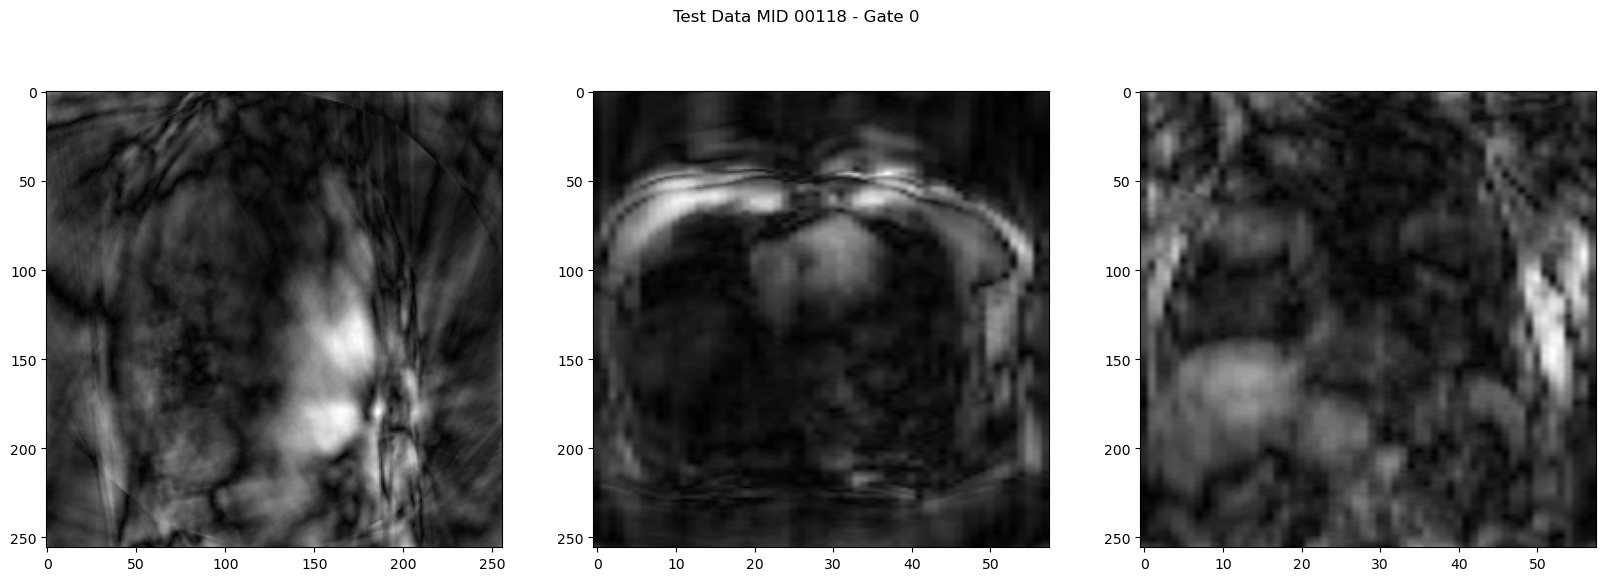

In [69]:
from scipy import ndimage
def rotate_90(img):
    return ndimage.rotate(img,-90)

output_0 = np.abs(output[...,0])
Nz, Ny, Nx = output_0.shape 

fig, axs = plt.subplots(1,3, figsize=(20,20))
axs[0].imshow((output_0[Nz//2, :, :]), cmap='gray')
axs[1].imshow(np.flipud(rotate_90(output_0[:, Ny//2, :])), aspect=Nz/Ny, cmap='gray')
axs[2].imshow(rotate_90(output_0[:, :, Nx//2]), aspect=Nz/Ny, cmap='gray')
fig.suptitle("Test Data MID 00118 - Gate 0", y=0.65)